In [1]:
!python --version

Python 3.12.12


In [2]:
!which python
!which jupyter

/home/DHJ/.conda/envs/py312/bin/python
/home/DHJ/.conda/envs/py312/bin/jupyter


In [3]:
import tensorcircuit as tc
import numpy as np
import matplotlib.pyplot as plt
import time


/tmp/ipykernel_4153973/591642020.py:37: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  if np.in1d(L//2, filled_indices) == False:
2025-10-18 17:46:03.259181: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1760780763.260299 4153973 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46731 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:27:00.0, compute capability: 8.6


ldb = 0.00 (1 / 15)


I0000 00:00:1760780764.960130 4153973 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0xf7adba0


ldb = 0.25 (2 / 15)
ldb = 0.50 (3 / 15)
ldb = 0.60 (4 / 15)
ldb = 0.70 (5 / 15)
ldb = 0.80 (6 / 15)
ldb = 0.90 (7 / 15)
ldb = 1.00 (8 / 15)
ldb = 1.10 (9 / 15)
ldb = 1.20 (10 / 15)
ldb = 1.30 (11 / 15)
ldb = 1.40 (12 / 15)
ldb = 1.50 (13 / 15)
ldb = 1.75 (14 / 15)
ldb = 2.00 (15 / 15)


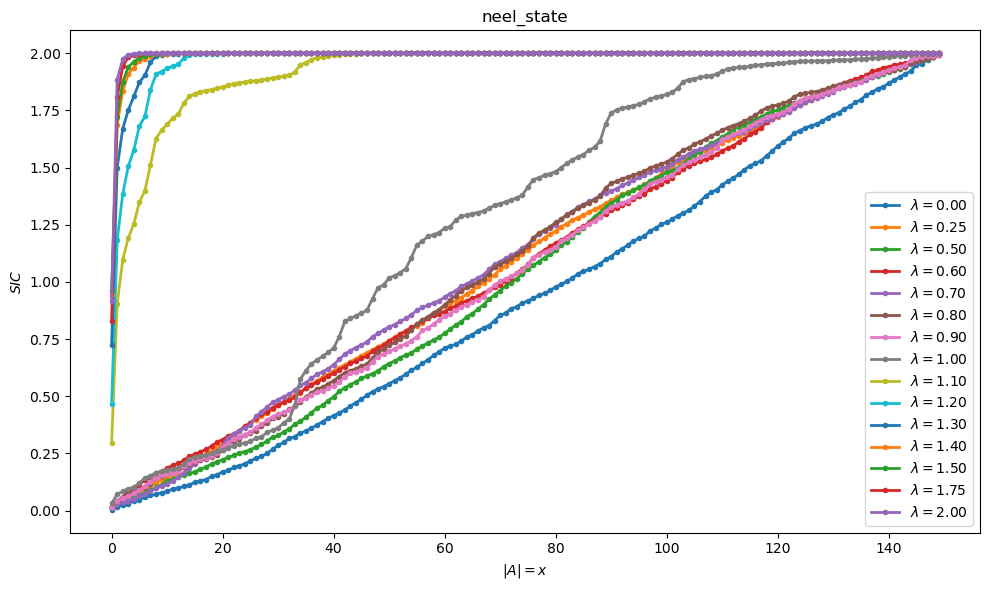

elapsed time: 2720.4 s


In [ ]:

K = tc.set_backend("numpy")
tc.set_dtype("complex128")

def gen_H_entangle_nambu(L):
    H = np.zeros((2*L+2, 2*L+2), dtype=np.complex128)

    H[L//2, L] = 1 / 2
    H[L, L//2] = 1 / 2
    H[L//2+L+1, L+L+1] = -1 / 2
    H[L+L+1, L//2+L+1] = -1 / 2

    return H

def gen_H_GAA_nambu(L, t, lbd, a, b, phi):
    H = np.zeros((2*L+2, 2*L+2), dtype=np.complex128)

    for i in range(L-1):
        H[i, i+1] = t / 2
        H[i+1, i] = t / 2
        H[i+L+1, i+1+L+1] = -t / 2
        H[i+1+L+1, i+L+1] = -t / 2

    for i in range(L):
        H[i, i] = 2 * lbd * np.cos(2*np.pi*i*b+phi) / (1-a*np.cos(2*np.pi*i*b+phi)) / 2
        H[i+L+1, i+L+1] = -H[i, i]

    return H

def gen_psi_0(state_name, L, f):
    if state_name == "random_state":
        filled_indices = np.random.choice(np.arange(L), size=L//f, replace=False)
        if np.in1d(L//2, filled_indices) == False:
            filled_indices = np.append(filled_indices, [L])
        alpha = tc.FGSSimulator.init_alpha(filled_indices, L+1)
    elif state_name == "neel_state":
        filled_indices = np.arange(0, L, f)
        if np.in1d(L//2, filled_indices) == False:
            filled_indices = np.append(filled_indices, [L])
        alpha = tc.FGSSimulator.init_alpha(filled_indices, L+1)
    elif state_name == "bipartite_state":
        filled_indices = np.arange(L//f, L)
        if np.in1d(L//2, filled_indices) == False:
            filled_indices = np.append(filled_indices, [L])
        alpha = tc.FGSSimulator.init_alpha(filled_indices, L+1)
    else:
        print("state name is wrong")
        exit(1)

    return alpha

def cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f):
    H_ent = gen_H_entangle_nambu(L)

    if state_name == "random_state":
        random_sample = 20
        SIC_array = np.zeros((len(lbd_array), steps, L//2, random_sample))
        alpha_0_array = [gen_psi_0(state_name, L, f) for _ in range(random_sample)]
        for r, alpha_0 in enumerate(alpha_0_array):
            for i, lbd in enumerate(lbd_array):
                print(f"r = {r+1} / {random_sample}, ldb = {lbd:.2f} ({i + 1} / {len(lbd_array)})")
                
                H_evo = gen_H_GAA_nambu(L, t, lbd, a, b, phi)
                system = tc.FGSSimulator(L+1, alpha=alpha_0)
                system.evol_ghamiltonian(2 * H_ent * np.pi/4)
                system.evol_ghamiltonian(2 * H_evo * pre)

                random_array = np.random.rand(steps)
                for j in range(steps):
                    for x in range(L//2):
                        E_list = np.arange(L//2-x, L//2+x+0.001, 1)
                        S_E = system.entropy(E_list)
                        S_R = system.entropy([L])
                        S_ER = system.entropy(np.append(E_list, L))
                        SIC_array[i, j, x, r] = S_E + S_R - S_ER
                    system.evol_ghamiltonian(2 * H_evo * dt * random_array[j])

    else:
        alpha_0 = gen_psi_0(state_name, L, f)
        SIC_array = np.zeros((len(lbd_array), steps, L//2))
        for i, lbd in enumerate(lbd_array):
            print(f"ldb = {lbd:.2f} ({i + 1} / {len(lbd_array)})")
            
            H_evo = gen_H_GAA_nambu(L, t, lbd, a, b, phi)
            system = tc.FGSSimulator(L+1, alpha=alpha_0)
            system.evol_ghamiltonian(2 * H_ent * np.pi/4)
            system.evol_ghamiltonian(2 * H_evo * pre)

            random_array = np.random.rand(steps)
            for j in range(steps):
                for x in range(L//2):
                    E_list = np.arange(L//2-x, L//2+x+0.001, 1)
                    S_E = system.entropy(E_list)
                    S_R = system.entropy([L])
                    S_ER = system.entropy(np.append(E_list, L))
                    SIC_array[i, j, x] = S_E + S_R - S_ER
                system.evol_ghamiltonian(2 * H_evo * dt * random_array[j])

    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    np.savez("data//" + file_name + ".npz", SIC_array=SIC_array)

def vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f):
    file_name = f"4 - SIC_of_x_{state_name}_f_{f}_L_{L}_a_{a:.1f}_lbd_{lbd_array[0]}_{lbd_array[-1]}_pre_{pre}_steps_{steps}_dt_{dt}"
    data = np.load("data//" + file_name + ".npz")
    SIC_array=data['SIC_array']

    plt.figure(figsize=(10, 6))

    for lbd_idx, lbd in enumerate(lbd_array):
        if state_name == "random_state":
            SIC_LTA_array = np.mean(SIC_array, axis=1)
            SIC_RSA_array = np.mean(SIC_LTA_array, axis=2)
            SIC_error_array = [np.sqrt(np.sum((SIC_LTA_array[lbd_idx, i, :] - SIC_RSA_array[lbd_idx, i]) ** 2) / (np.size(SIC_LTA_array, 2) - 1)) for i in range(np.size(SIC_LTA_array, 1))]
            plt.errorbar(range(L//2), SIC_RSA_array[lbd_idx, :] / np.log(2), SIC_error_array / np.log(2), linewidth=2, marker='.', label=rf"$\lambda={lbd:.2f}$")
        else:
            plt.plot(range(L//2), np.mean(SIC_array[lbd_idx, :, :] / np.log(2), 0), marker='.', linewidth=2, label=rf"$\lambda={lbd:.2f}$")

    plt.title(state_name)
    plt.legend()
    plt.xlabel(r'$|A|=x$')
    plt.ylabel(r'$SIC$')
    plt.tight_layout()
    plt.savefig("fig//" + file_name + ".png", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    np.random.seed(123)
    state_name = "neel_state"
    f = 2
    L = 300
    t = 1
    lbd_array = np.concatenate((np.arange(0, 0.5, 0.25), np.arange(0.5, 1.5, 0.1), np.arange(1.5, 2.0+1e-3, 0.25)))
    a = 0
    b = 2 / (np.sqrt(5) - 1)
    phi = np.pi/4
    pre = 10000
    steps = 10
    dt = 10

    start_time = time.time()
    cal_SIC_of_x(state_name, L, t, lbd_array, a, b, phi, pre, steps, dt, f)
    vis_SIC_of_x(state_name, L, lbd_array, a, pre, steps, dt, f)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")


In [6]:
import jax
print(jax.devices())

[cuda(id=0)]


In [8]:
import os
print(os.cpu_count())  # 输出可用的CPU核心数
%env OMP_NUM_THREADS=8  # 设置OpenMP线程数，适用于NumPy等库


192
env: OMP_NUM_THREADS=8  # 设置OpenMP线程数，适用于NumPy等库
